In [1]:
import requests
import csv
import calendar,time,datetime
import warnings
warnings.filterwarnings("ignore")
current_time_exact= datetime.datetime.now()
current_time=current_time_exact.strftime("%Y-%m-%d %H:%M:%S")
current_epoch_time=calendar.timegm(time.strptime(current_time, '%Y-%m-%d %H:%M:%S'))
currency="BTC"
URL="https://query1.finance.yahoo.com/v7/finance/download/"+currency+"-USD?period1=1411862400&period2="+str(current_epoch_time)+"&interval=1d&events=history&includeAdjustedClose=true"
print(URL)
req = requests.get(URL)
url_content = req.content
csv_file = open('BTC-USD.csv', 'wb')
csv_file.write(url_content)
csv_file.close()


https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1411862400&period2=1621005464&interval=1d&events=history&includeAdjustedClose=true


In [2]:
import pandas as pd
# data = pd.read_csv(currency+"-USD.csv")
df = pd.read_csv("BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-28,399.471008,401.016998,374.332001,377.181000,377.181000,23613300.0
1,2014-09-29,376.928009,385.210999,372.239990,375.467010,375.467010,32497700.0
2,2014-09-30,376.088013,390.976990,373.442993,386.944000,386.944000,34707300.0
3,2014-10-01,387.427002,391.378998,380.779999,383.614990,383.614990,26229400.0
4,2014-10-02,383.988007,385.497009,372.946014,375.071991,375.071991,21777700.0


Text(0, 0.5, 'Close Price (USD)')

<Figure size 1152x576 with 0 Axes>

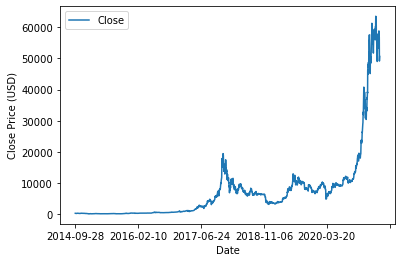

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt= df.plot(x='Date', y='Close');
plt.set_xlabel("Date")
plt.set_ylabel("Close Price (USD)")

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

#Keeping only Adjusted Close(Adj .Close) as only this will be helpful in predicting stock prices
df=df[['Adj Close']]
#Replacing NaN with 0
df['Adj Close'] = df['Adj Close'].fillna(0) 
#Declaring a forecast variable('n' days) to which forecast is to be made 'n' days into the future
forecast=30 #This means at a particular day I will be able to know the stock price after 30 days.
#Creating a Prediction Column which is a copy of Adj .Close but with 'forcast' number of rows shifted up
df['Prediction']=df[['Adj Close']].shift(-forecast)
#Take a look at the new Data
print(df.tail())

         Adj Close  Prediction
2416  55859.796875         NaN
2417  56704.574219         NaN
2418  49150.535156         NaN
2419  49716.191406         NaN
2420  50626.945313         NaN


In [5]:
#Creating X and y independent and dependent variables respectively 
X= np.array(df.drop(['Prediction'],1))#Dropping the prediction Column
X=X[:-forecast] #Deleting the last 'n' rows
y=np.array(df.drop(['Adj Close'],1))#Dropping the Adj Close Column
y=y[:-forecast] #Deleting the last 'n' rows
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2) #Split the data into train and test


In [6]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [7]:
lr=LinearRegression()
DT= DecisionTreeRegressor(random_state = 0)
RF= RandomForestRegressor(n_estimators = 15, random_state = 0)
XGB= XGBRegressor(objective ='reg:linear',n_estimators = 30, seed = 123)

In [8]:
params = {'n_neighbors':[2,3,4,5,6,7,8,9]} #using gridsearch to find the best parameter
knn = neighbors.KNeighborsRegressor()
knn = GridSearchCV(knn, params, cv=5)


In [9]:
models=[lr,DT,RF,XGB,knn]

In [10]:
for model in models:
    model.fit(X_train,y_train)
    pred = model.predict(X_test)  
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print("RMSE : % f" %(rmse))


RMSE :  3104.637266
RMSE :  3148.061859
RMSE :  2680.000759
[15:17:48] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  2600.819300
RMSE :  2570.769279


In [11]:
#Now when we have made the model now is the forecast time,so we use the last 'n' rows of the df
#creating X_forecast which will store the 'n' rows Adj .Close values
x_forecast=np.array(df.drop(['Prediction'],1))
x_forecast=x_forecast[-forecast:]

In [12]:
#using X_forecast to make prediction for the 'n' days using the model created
LR_forecast=lr.predict(x_forecast)
DT_forecast=DT.predict(x_forecast) 
RF_forecast=RF.predict(x_forecast) 
XGB_forecast=XGB.predict(x_forecast) 
knn_forecast = knn.predict(x_forecast)

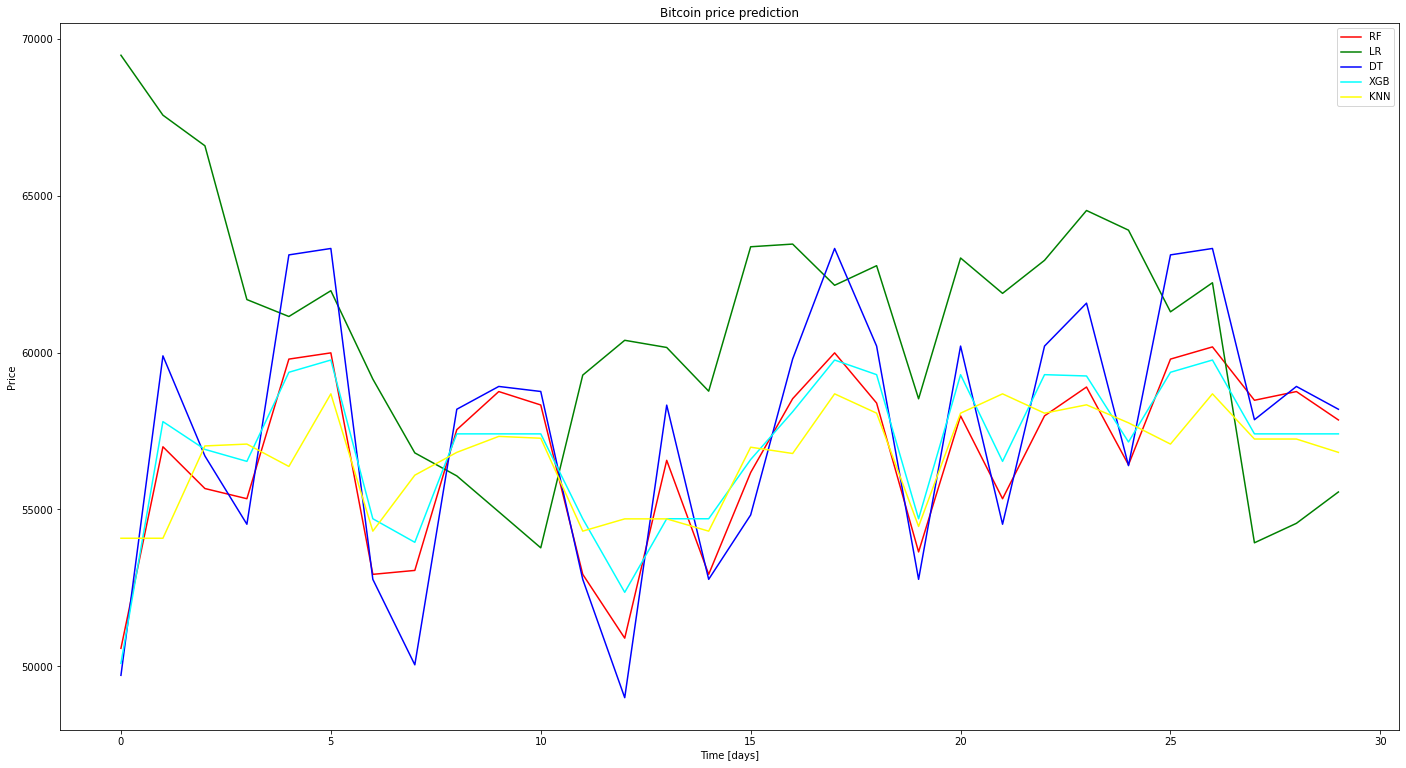

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,13))
plt.plot(RF_forecast, label="RF", color='red')
plt.plot(LR_forecast, label="LR", color='green')
plt.plot(DT_forecast, label="DT", color='blue')
plt.plot(XGB_forecast, label="XGB", color='cyan')
plt.plot(knn_forecast, label="KNN", color='yellow')
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best') 
plt.show();